In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import os
os.chdir('..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

from utils import *

from tqdm.notebook import tqdm

np.set_printoptions(precision=4, suppress=True)

In [3]:
events = [1.1, 5.2, 7.1, 12.1, 25]

video of length 30s, hop length 0.5 and frame length 0.5

In [4]:
n_hops = 60
start_time = 0
end_time = 30
nn_hop_length_half = 0.25

In [5]:
time = np.linspace(start_time + nn_hop_length_half, end_time - nn_hop_length_half, n_hops)
time

array([ 0.25,  0.75,  1.25,  1.75,  2.25,  2.75,  3.25,  3.75,  4.25,
        4.75,  5.25,  5.75,  6.25,  6.75,  7.25,  7.75,  8.25,  8.75,
        9.25,  9.75, 10.25, 10.75, 11.25, 11.75, 12.25, 12.75, 13.25,
       13.75, 14.25, 14.75, 15.25, 15.75, 16.25, 16.75, 17.25, 17.75,
       18.25, 18.75, 19.25, 19.75, 20.25, 20.75, 21.25, 21.75, 22.25,
       22.75, 23.25, 23.75, 24.25, 24.75, 25.25, 25.75, 26.25, 26.75,
       27.25, 27.75, 28.25, 28.75, 29.25, 29.75])

In [6]:
cumstep = get_cumstep(time, events)
cumstep

array([0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5.])

In [7]:
def create_slider(value=0.0):
    slider = widgets.FloatSlider(
        value=value,
        min=start_time,
        max=end_time,
        step=0.05,
        readout_format='.1f'
    )
    return slider

def show(**kwargs):
    plt.close('all')
    
    events = []
    for i, slider in enumerate(sliders.children):
        events.append(slider.value)
        
    cumstep = get_cumstep(time, events)
        
    fig, ax1 = plt.subplots(figsize=(15, 4))
    ax2 = ax1.twinx()

    for t in time:
        ax2.vlines(t, 0, 1, color='k', linestyle='dotted', linewidth=1, alpha=0.5)
    
    ax1.step(time, cumstep, where='post');
    print(cumstep)

    for i, event in enumerate(events):
        ax2.vlines(event, 0, 1, color='r', linestyle='dotted', linewidth=1, alpha=0.9)
        
    plt.show()

sliders = widgets.VBox(
    children=[create_slider(value=e) for e in events], 
    layout=widgets.Layout(flex_flow='row wrap'))

out = widgets.interactive_output(show, {
        f'{slider}': slider for slider in sliders.children
    })

display(sliders, out)

Output()

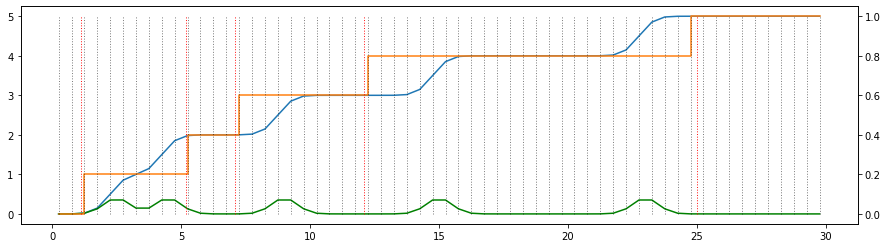

In [38]:
from scipy.stats import norm

def gaussian(x, c=1):
    pdf = norm.pdf(time, loc=x, scale=0.5)
    return pdf / pdf.sum() * c

y = gaussian(2.5) + gaussian(4.5) + gaussian(9) + gaussian(15) + gaussian(23)
# y = gaussian(1.1) + gaussian(5.2) + gaussian(7.1) + gaussian(12.1) + gaussian(25)

cumsum = np.cumsum(y)
cumstep = get_cumstep(time, events)

fig, ax1 = plt.subplots(figsize=(15, 4))
ax2 = ax1.twinx()

ax1.plot(time, cumsum);
ax1.plot(time, y, color='green');
ax1.step(time, cumstep, where='post');
# ax1.plot(time, cumstep);

for t in time:
    ax2.vlines(t, 0, 1, color='k', linestyle='dotted', linewidth=1, alpha=0.5)
    
for i, event in enumerate(events):
    ax2.vlines(event, 0, 1, color='r', linestyle='dotted', linewidth=1, alpha=0.9)

plt.show()

In [39]:
# obj
np.abs(cumstep - cumsum).sum()

16.500064313644373

In [40]:
def discretize(time, events):
    discrete_events = []

    closest = lambda array, value: np.abs(array - value).argmin()

    for e in events:
        idx = closest(time, e)
        discrete_events.append(idx)
    discrete_events

#     discrete_events = [0] + discrete_events
    return discrete_events

discrete_events = discretize(time, events)

In [41]:
def pairs(array):
    for i in range(len(array)):
        if i < len(array) - 1:
            yield array[i: i + 2]

def dist(t_plus_delta_0, t_plus_delta_1, cumsum, c, a=10):
    N = len(cumsum)
    
    if t_plus_delta_0 < 0 or t_plus_delta_0 > N:
        return np.inf
    
    if t_plus_delta_1 < 0 or t_plus_delta_1 > N:
        return np.inf

    if t_plus_delta_1 - t_plus_delta_0 <= 0:
        return np.inf

#     print(cumsum[0])
#     print((cumsum[1: -1] - cumsum[0: -2]).shape)
    f = np.concatenate(([cumsum[0]], cumsum[1: -1] - cumsum[0: -2]))
    
    return np.abs(cumsum[t_plus_delta_0: t_plus_delta_1] - c).sum() + a * f[t_plus_delta_0 + 1: t_plus_delta_1].sum()


def objective(discrete_events, cumsum):
    obj = dist(0, discrete_events[0], cumsum, 0)
        
    for c, (i, j) in enumerate(pairs(discrete_events)):
        d = dist(i, j, cumsum, c + 1)
        obj += d
    
    last = len(discrete_events)
    obj += dist(discrete_events[-1], len(cumsum), cumsum, last)

    return obj


def backtrack(start, backtracking):
    backtracked = [start]
    for i in reversed(range(backtracking.shape[1] - 1)):
        start = backtracking[start, i + 1]
        backtracked.append(start)
    return backtracked[::-1]
        
    
def dtw(discrete_events, cumsum, N=5):
    deltas = np.arange(-N, N + 1)

    distances = np.zeros((len(deltas), len(discrete_events)))
    backtracking = np.zeros_like(distances, dtype=int)

    t_1 = discrete_events[0]
    t_n = discrete_events[-1]
    end = len(cumsum)
    last = len(discrete_events)

    for i, delta_1 in enumerate(deltas):
        t_plus_delta_1 = t_1 + delta_1
        d = dist(0, t_plus_delta_1, cumsum, 0)
        distances[i, 0] = d

    backtracking[:, 0] = range(len(backtracking))

    for c, (t_0, t_1) in enumerate(pairs(discrete_events)):
        for j, delta_1 in enumerate(deltas):
            min_d = np.inf

            for i, delta_0 in enumerate(deltas):
                t_plus_delta_0 = t_0 + delta_0
                t_plus_delta_1 = t_1 + delta_1

                d = dist(t_plus_delta_0, t_plus_delta_1, cumsum, c + 1)

                prev_d = distances[i, c]
                next_d = d + prev_d

                if next_d < min_d:
                    min_d = next_d
                    backtracking[j, c + 1] = i
                    distances[j, c + 1] = min_d

    for i, delta_0 in enumerate(deltas):
        t_plus_delta_0 = t_n + delta_0
        prev_d = distances[i, -1]
        d = dist(t_plus_delta_0, end, cumsum, last)
        distances[i, -1] = prev_d + d 

    start = np.argmin(distances[:, -1])
    backtracked = backtrack(start, backtracking)

    new_discrete_events = []

    for delta_index, discrete_event in zip(backtracked, discrete_events):
        new_discrete_event = discrete_event + deltas[delta_index]
        new_discrete_events.append(new_discrete_event)

    new_cumstep = np.zeros_like(cumsum)
    for idx in new_discrete_events:
        new_cumstep[idx] += 1

    new_cumstep = np.cumsum(new_cumstep)
    return new_cumstep

In [42]:
objective(discrete_events, cumsum)

65.01198859756441

In [43]:
new_cumstep = dtw(discrete_events, cumsum)

# objectives
print(np.abs(cumstep - cumsum).sum())
print(np.abs(new_cumstep - cumsum).sum())

16.500064313644373
4.1321769676660995


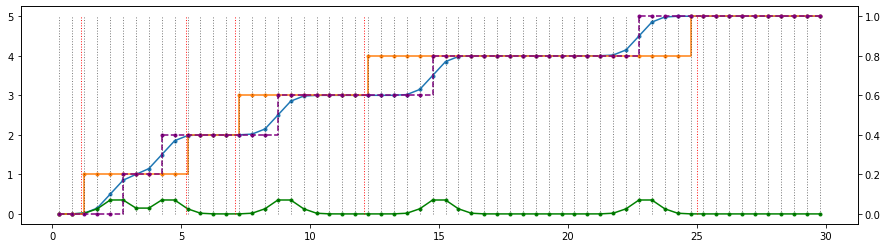

In [44]:
fig, ax1 = plt.subplots(figsize=(15, 4))
ax2 = ax1.twinx()

markersize = 3
ax1.plot(time, cumsum, marker='o', markersize=markersize);
# ax1.step(time, cumsum, marker='o', markersize=markersize, where='post');
ax1.plot(time, y, color='green', marker='o', markersize=markersize);
ax1.step(time, cumstep, where='post', marker='o', markersize=markersize);
ax1.step(time, new_cumstep, where='post', linestyle='--', color='purple', marker='o', markersize=markersize);

for t in time:
    ax2.vlines(t, 0, 1, color='k', linestyle='dotted', linewidth=1, alpha=0.5)
    
for i, event in enumerate(events):
    ax2.vlines(event, 0, 1, color='r', linestyle='dotted', linewidth=1, alpha=0.9)

plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

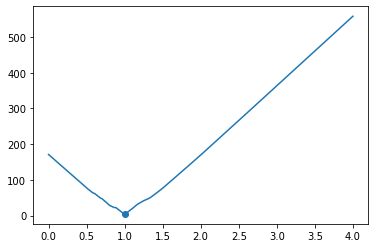

In [45]:
N = 6

consts = np.linspace(0, 4, 200)

best_obj = np.inf
best_const = None
objs = []
for const in tqdm(consts):
    cumsum_times_const = cumsum * const
    new_cumstep = dtw(discrete_events, cumsum_times_const, N)
    obj = np.abs(new_cumstep - cumsum_times_const).sum() 
    if obj < best_obj:
        best_obj = obj
        best_const = const
        
    objs.append(obj)
#     print(f'c: {const:.1f} | {obj:.3f}')

plt.scatter([best_const], [best_obj])
plt.plot(consts, objs);

In [46]:
new_cumsum = cumsum * best_const

new_cumstep = dtw(discrete_events, new_cumsum)

# objectives
print(np.abs(cumstep - cumsum).sum())
print(np.abs(new_cumstep - cumsum).sum())

16.500064313644373
4.1321769676660995


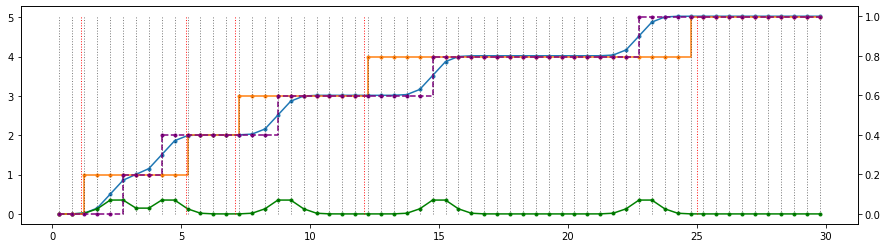

In [47]:
fig, ax1 = plt.subplots(figsize=(15, 4))
ax2 = ax1.twinx()

markersize = 3
ax1.plot(time, new_cumsum, marker='o', markersize=markersize);
# ax1.step(time, cumsum, marker='o', markersize=markersize, where='post');
ax1.plot(time, y, color='green', marker='o', markersize=markersize);
ax1.step(time, cumstep, where='post', marker='o', markersize=markersize);
ax1.step(time, new_cumstep, where='post', linestyle='--', color='purple', marker='o', markersize=markersize);

for t in time:
    ax2.vlines(t, 0, 1, color='k', linestyle='dotted', linewidth=1, alpha=0.5)
    
for i, event in enumerate(events):
    ax2.vlines(event, 0, 1, color='r', linestyle='dotted', linewidth=1, alpha=0.9)

plt.show()

In [48]:
new_cumstep

array([0., 0., 0., 0., 0., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5.])